In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from feature_engine.encoding import (
    CountFrequencyEncoder
)

# import train_test_split
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.feature_selection import VarianceThreshold

In [87]:
url = 'dataset/train.csv'
train = pd.read_csv(url)
train.head()

,ID,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,478,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K
1,479,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K
2,480,2004,NaN,122244,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,<=50K
3,481,1984,Pemerintah daerah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K
4,482,2000,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,<=50K


## Data Preprocessing

In [88]:
# Dropping unnecessary column
train.drop('ID', axis=1, inplace=True)
train.head(2)

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K
1,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K


In [89]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)
    
    missing_data = df.isnull().sum().sum()
    
    print(f'There are {missing_data} missing values in the dataset.')
    print(f'There are {df.duplicated().sum().sum()} duplicated values in the dataset.')
    print('-' *50)
    
    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))
        print('-' *50)


In [90]:
check_data(train)

--------------------------------------------------
There are 2956 missing values in the dataset.
There are 35 duplicated values in the dataset.
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Tahun Kelahiran          0
fnlwgt                   0
Pendidikan               0
Jenjang Pendidikan       0
Status                   0
Hubungan                 0
Etnis                    0
sex                      0
pendapatan               0
pengeluaran              0
hours per week           0
Asal Negara              0
jumlah_anak              0
income                   0
dtype: int64
--------------------------------------------------


## Feature Engineering

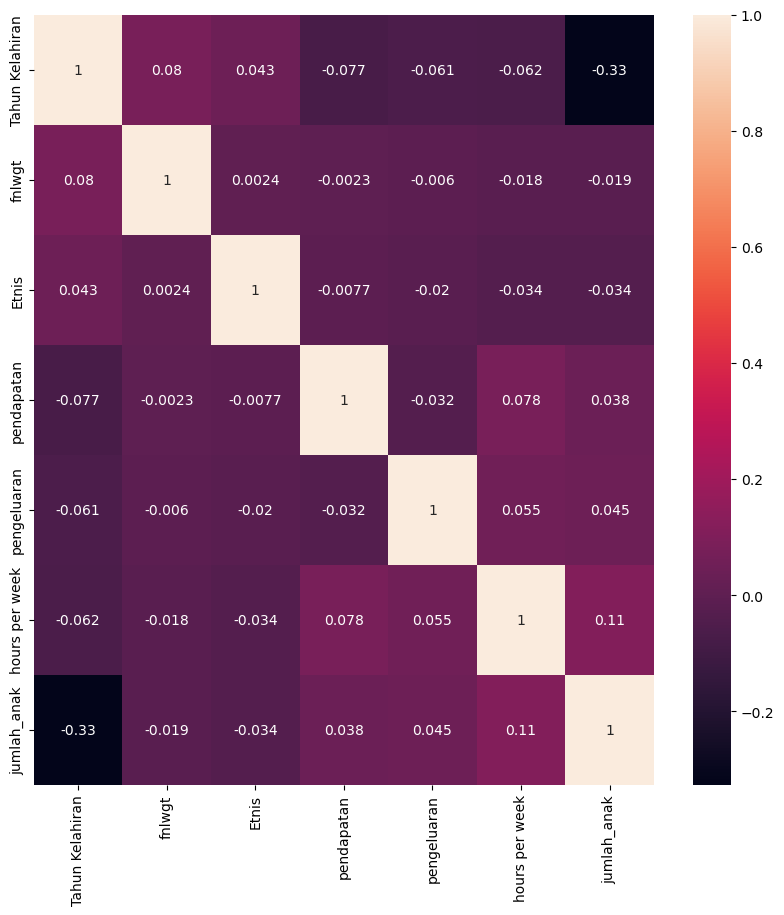

In [91]:
num_cols = [var for var in train.columns if train[var].dtypes != 'O']
corr_mat = train[num_cols].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True)
plt.show()

Not using linear based model

### Fixing data format

In [92]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

for col in train[cat_cols]:
    print(f'{col}: {train[col].unique()}')
    print('-' *50)

Kelas Pekerjaan: ['Swasta' nan 'Pemerintah daerah' 'Pengusaha berbadan hukum'
 'Pemerintah pusat' 'Pengusaha perorangan' 'Pemerintah negara'
 'Tanpa bayaran' 'Tidak bekerja']
--------------------------------------------------
Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Diploma' 'Asosiasi akademik' 'kelas 10'
 'kelas 9' 'kelas 7-8' 'Asosiasi vokasional' 'kelas 11' 'kelas 5-6'
 'Proffesor' 'kelas 12' 'Doktor' 'kelas 1-4' 'TK']
--------------------------------------------------
Jenjang Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Kuliah' 'vokasi Grad_1' 'SMA_1' 'SMP_2'
 'SMP_1' 'vokasi Grad_2' 'SMA_2' 'SD_2' 'Doktor' 'SMA_3' 'Proffesor'
 'SD_1' 'TK']
--------------------------------------------------
Status: ['Menikah' 'Belum-menikah' 'Cerai' 'Duda/Janda' 'Rencana Cerai'
 'Menikahi tentara' 'LDM']
--------------------------------------------------
Pekerjaan: ['Eksekutif Manager' nan 'Transportasi dan Pengangkutan'
 'Spesialis Profesional' 'Dukungan Teknis' 'Pekerjaan Kerajinan' 'Sales'

Fixing `Pendidikan` column

In [93]:
train['Pendidikan'].value_counts()

Pendidikan
SMA Grad               8387
Diploma                5820
Sarjana                4261
Magister               1407
Asosiasi vokasional    1111
kelas 11                933
Asosiasi akademik       876
kelas 10                729
kelas 7-8               526
Proffesor               462
kelas 9                 409
kelas 12                354
Doktor                  330
kelas 5-6               282
kelas 1-4               140
TK                       42
Name: count, dtype: int64

In [94]:
# replace kelas 10, kelas 11, kelas 12 with SMA
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 10', 'kelas 11', 'kelas 12'], 'SMA')

# replace kelas 7-8, kelas 9 with SMP
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 7-8', 'kelas 9'], 'SMP')

# replace kelas 1-4, kelas 5-6 with SD
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 1-4', 'kelas 5-6'], 'SD')

# # replace
# train['Pendidikan'] = train['Pendidikan'].replace(['Diploma', 'Asosiasi akademik', 'Asosiasi vokasional',
#                                                    'Sarjana', 'Magister', 'Doktor', 'Proffesor', 'SMA Grad'], 'Pendidikan Tinggi')

train['Pendidikan'].value_counts()

Pendidikan
SMA Grad               8387
Diploma                5820
Sarjana                4261
SMA                    2016
Magister               1407
Asosiasi vokasional    1111
SMP                     935
Asosiasi akademik       876
Proffesor               462
SD                      422
Doktor                  330
TK                       42
Name: count, dtype: int64

Fixing `Status` column

In [95]:
train['Status'].value_counts()

Status
Menikah             12012
Belum-menikah        8505
Cerai                3564
Rencana Cerai         826
Duda/Janda            812
LDM                   332
Menikahi tentara       18
Name: count, dtype: int64

In [96]:
train['Status'] = train['Status'].replace(['Menikahi tentara', 'LDM'], 'Menikah')
# replacing menikahi tentara with Menikah

train['Status'].value_counts()

Status
Menikah          12362
Belum-menikah     8505
Cerai             3564
Rencana Cerai      826
Duda/Janda         812
Name: count, dtype: int64

Fixing `Hubungan` column (**PENDING)

In [97]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

Fixing `Kelas Pekerjaan` column

In [98]:
train['Kelas Pekerjaan'].value_counts()

Kelas Pekerjaan
Swasta                      18114
Pengusaha perorangan         2043
Pemerintah daerah            1705
Pemerintah negara            1053
Pengusaha berbadan hukum      894
Pemerintah pusat              766
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

In [99]:
# replacing with sektor pemerintah affiliated
train['Kelas Pekerjaan'] = train['Kelas Pekerjaan'].replace(['Pemerintah pusat', 'Pemerintah daerah',
                                                             'Pemerintah negara'], 'Sektor Pemerintah')

# train['Kelas Pekerjaan'] = train['Kelas Pekerjaan'].replace(['Tanpa bayaran', 'Tidak bekerja'], '')

train['Kelas Pekerjaan'].value_counts()

Kelas Pekerjaan
Swasta                      18114
Sektor Pemerintah            3524
Pengusaha perorangan         2043
Pengusaha berbadan hukum      894
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

In [100]:
# no_income feature column
train['no_income'] = train['Kelas Pekerjaan'].apply(lambda x: 1 if x == 'Tanpa bayaran' or x == 'Tidak bekerja' else 0)
train['no_income'].value_counts()

no_income
0    26050
1       19
Name: count, dtype: int64

Fixing `Jenjang Pendidikan` column

In [101]:
train['Jenjang Pendidikan'].value_counts()

Jenjang Pendidikan
SMA Grad         8387
Kuliah           5820
Sarjana          4261
Magister         1407
vokasi Grad_2    1111
SMA_2             933
vokasi Grad_1     876
SMA_1             729
SMP_1             526
Doktor            462
SMP_2             409
SMA_3             354
Proffesor         330
SD_2              282
SD_1              140
TK                 42
Name: count, dtype: int64

In [102]:
# replace SMA_1, SMA_2, SMA_3 with SMA
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SMA_1', 'SMA_2', 'SMA_3'], 'SMA')

# replace SMP_1, SMP_2, SMP_3 with SMP
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SMP_1', 'SMP_2', 'SMP_3'], 'SMP')

# replace SD_1, SD_2, with SD
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SD_1', 'SD_2'], 'SD')

# replace vokasi Grad_1, vokasi Grad_2 with vokasi Grad
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['vokasi Grad_1', 'vokasi Grad_2'], 'Vokasi Grad')

train['Jenjang Pendidikan'].value_counts()

Jenjang Pendidikan
SMA Grad       8387
Kuliah         5820
Sarjana        4261
SMA            2016
Vokasi Grad    1987
Magister       1407
SMP             935
Doktor          462
SD              422
Proffesor       330
TK               42
Name: count, dtype: int64

Fixing `Asal Negara` column

In [103]:
train['Asal Negara'].value_counts()

Asal Negara
United-States                 23355
Mexico                          532
?                               458
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Poland                           48
Columbia                         48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Greece                           25
Ecuador         

In [104]:
# replace ? with missing value
train['Asal Negara'] = train['Asal Negara'].replace(['?'], np.nan)

# replace "Hong" with "Hong Kong"
train['Asal Negara'] = train['Asal Negara'].replace(['Hong'], 'Hong Kong')

train['Asal Negara'].value_counts()

Asal Negara
United-States                 23355
Mexico                          532
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Columbia                         48
Poland                           48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Ecuador                          25
Greece                           25
Peru            

In [105]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

for col in train[cat_cols]:
    print(f'{col}: {train[col].unique()}')
    print('-' *50)

Kelas Pekerjaan: ['Swasta' nan 'Sektor Pemerintah' 'Pengusaha berbadan hukum'
 'Pengusaha perorangan' 'Tanpa bayaran' 'Tidak bekerja']
--------------------------------------------------
Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Diploma' 'Asosiasi akademik' 'SMA' 'SMP'
 'Asosiasi vokasional' 'SD' 'Proffesor' 'Doktor' 'TK']
--------------------------------------------------
Jenjang Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Kuliah' 'Vokasi Grad' 'SMA' 'SMP' 'SD'
 'Doktor' 'Proffesor' 'TK']
--------------------------------------------------
Status: ['Menikah' 'Belum-menikah' 'Cerai' 'Duda/Janda' 'Rencana Cerai']
--------------------------------------------------
Pekerjaan: ['Eksekutif Manager' nan 'Transportasi dan Pengangkutan'
 'Spesialis Profesional' 'Dukungan Teknis' 'Pekerjaan Kerajinan' 'Sales'
 'Layanan Lainnya' 'Pengelola Kebersihan' 'Inspeksi dan Operasi Mesin'
 'Pertanian dan Perikanan' 'Administratif dan Kantor'
 'Layanan Perlindungan' 'Pembantu Rumah Tangga' 'Angkatan B

### Encoding categorical columns

In [106]:
train[cat_cols].head()

,Kelas Pekerjaan,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,sex,Asal Negara,income
0,Swasta,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,Male,United-States,>50K
1,Swasta,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,Female,United-States,<=50K
2,NaN,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,Female,United-States,<=50K
3,Sektor Pemerintah,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,Male,United-States,<=50K
4,Swasta,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,Male,United-States,<=50K


### Feature Selection

In [107]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)

    missing_data = df.isnull().sum().sum()
    print('Missing data:', missing_data)

    duplicated_data = df.duplicated().sum().sum()
    print('Duplicated data:', duplicated_data)

    print('-' *50)

    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))

    print('-' *50)

check_data(train)

--------------------------------------------------
Missing data: 3414
Duplicated data: 36
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Asal Negara            458
Tahun Kelahiran          0
pendapatan               0
income                   0
jumlah_anak              0
hours per week           0
pengeluaran              0
Etnis                    0
sex                      0
Hubungan                 0
Status                   0
Jenjang Pendidikan       0
Pendidikan               0
fnlwgt                   0
no_income                0
dtype: int64
--------------------------------------------------


In [108]:
# train 2 ini untuk encode manual
train_2 = train.copy() 

In [109]:
missing_cols = ['Kelas Pekerjaan', 'Pekerjaan', 'Asal Negara']

for col in missing_cols:
    train_2[col] = train_2[col].fillna(method='ffill')

# drop duplucated
train_2.drop_duplicates(inplace=True)

In [110]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)

    missing_data = df.isnull().sum().sum()
    print('Missing data:', missing_data)

    duplicated_data = df.duplicated().sum().sum()
    print('Duplicated data:', duplicated_data)

    print('-' *50)

    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))

    print('-' *50)

check_data(train_2)

--------------------------------------------------
Missing data: 0
Duplicated data: 0
--------------------------------------------------
--------------------------------------------------


# Feature Selection Train 2

#### Using Chi2

In [111]:
train_2.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K,0
1,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K,0
2,2004,Swasta,122244,SMA Grad,SMA Grad,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,<=50K,0
3,1984,Sektor Pemerintah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K,0
4,2000,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,<=50K,0


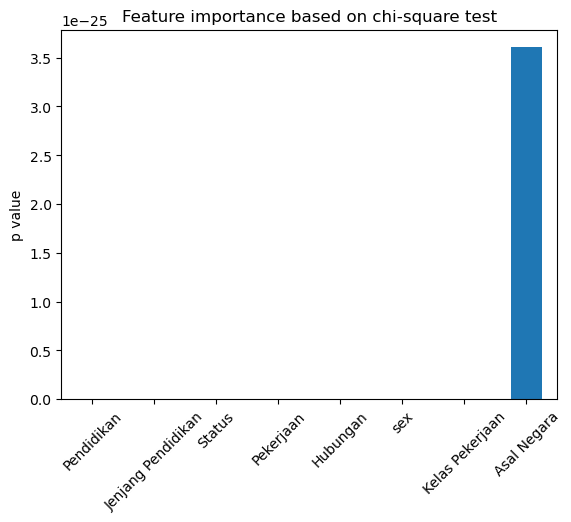

In [112]:
from scipy.stats import chi2_contingency

le = LabelEncoder()
train_chi = train_2.copy()

train_chi = train_chi.select_dtypes(include='object')

le = LabelEncoder()
train_chi['income'] = le.fit_transform(train_chi['income'])


X = train_chi.drop(['income'], axis=1)
y = train_chi['income']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

chi_ls = []

for feature in X_train.columns:
    c = pd.crosstab(y_train, X_train[feature])
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

pd.Series(chi_ls, index=X_train.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')
plt.show()

In [113]:
selected = pd.Series(chi_ls, index=X_train.columns).sort_values(
    ascending=True)[0:7].index

selected

Index(['Pendidikan', 'Jenjang Pendidikan', 'Status', 'Pekerjaan', 'Hubungan',
       'sex', 'Kelas Pekerjaan'],
      dtype='object')

#### Univariate Selection

In [114]:
train_anova = train_2.copy()

mapping_pendidikan = {
    'TK': 0,
    'SD' : 1,
    'SMP': 2,
    'SMA': 3,
    'SMA Grad': 4,
    'Diploma': 5,
    'Asosiasi akademik': 6,
    'Asosiasi vokasional': 7,
    'Sarjana': 8,
    'Magister': 9,
    'Doktor': 10,
    'Proffesor': 11
}

# Apply mapping
train_anova['Pendidikan'] = train_anova['Pendidikan'].map(mapping_pendidikan)

mapping_status = {
    'Belum-menikah': 0,
    'Menikah': 1,
    'Duda/Janda': 2,
    'Cerai': 3,
    'Rencana Cerai': 4
}

train_anova['Status'] = train_anova['Status'].map(mapping_status)

mappingKelas_Pekerjaan = {
    'Tidak bekerja': 0,
    'Tanpa bayaran': 1,
    'Swasta': 2,
    'Pengusaha perorangan': 3,
    'Pengusaha berbadan hukum': 4,
    'Sektor Pemerintah': 5
}

# Apply mapping
train_anova['Kelas Pekerjaan'] = train_anova['Kelas Pekerjaan'].map(mappingKelas_Pekerjaan)

mapping_pekerjaan = {
    'Eksekutif Manager': 1,
    'Spesialis Profesional': 2,
    'Dukungan Teknis': 3,
    'Administratif dan Kantor': 4,
    'Sales': 5,
    'Transportasi dan Pengangkutan': 6,
    'Inspeksi dan Operasi Mesin': 7,
    'Pengelola Kebersihan': 8,
    'Pekerjaan Kerajinan': 9,
    'Pertanian dan Perikanan': 10,
    'Layanan Perlindungan': 11,
    'Layanan Lainnya': 12,
    'Pembantu Rumah Tangga': 13,
    'Angkatan Bersenjata': 14
}

# Apply mapping
train_anova['Pekerjaan'] = train_anova['Pekerjaan'].map(mapping_pekerjaan)

mapping_jenjangpendidikan = {
    'TK': 0,
    'SD': 1,
    'SMP': 2,
    'SMA': 3,
    'SMA Grad': 4,
    'Vokasi Grad': 5,
    'Kuliah': 6,
    'Sarjana': 7,
    'Magister': 8,
    'Doktor': 9,
    'Proffesor': 10
}

# Apply mapping
train_anova['Jenjang Pendidikan'] = train_anova['Jenjang Pendidikan'].map(mapping_jenjangpendidikan)

mapping_countries = {
    'United-States': 'United States',
    'Trinadad&Tobago': 'Trinidad and Tobago',
    'Columbia': 'Colombia',
    'South': 'South Africa',
    'Holand-Netherlands': 'Netherlands',
    'Hong': 'Hong Kong',
    'Outlying-US(Guam-USVI-etc)': 'United States (Guam, USVI, etc.)',
    'Dominican-Republic': 'Dominican Republic',
    'El-Salvador': 'El Salvador',
    'Puerto-Rico': 'Puerto Rico',
    'Cambodia': 'Cambodia',
    'Scotland': 'United Kingdom',
    'Yugoslavia': 'Serbia'
}

mapping_status_keluarga = {
    'Tidak dalam Keluarga': 0,
    'Belum Menikah': 1,
    'Kerabat': 2,
    'Istri': 3,
    'Suami': 4,
    'Punya Anak': 5
}

# Apply mapping
train_anova['Hubungan'] = train_anova['Hubungan'].map(mapping_status_keluarga)

# Apply mapping
train_anova['Asal Negara'] = train_anova['Asal Negara'].map(mapping_countries).fillna(train_anova['Asal Negara'])


In [115]:
le = LabelEncoder()

for cols in ('sex', 'income'):
    train_anova[cols] = le.fit_transform(train_anova[cols])
    train_anova[cols] = le.fit_transform(train_anova[cols])

In [116]:
train_anova_target = train_anova.copy()
trai_anova_onehot = train_anova.copy()
train_anova_label = train_anova.copy()

In [117]:
cols_fe = ['Asal Negara']

# frequency encoding
freq_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=cols_fe,
    missing_values='ignore'
)
train_anova_frequency = freq_enc.fit_transform(train_anova)

# target encoding
target_enc = ce.TargetEncoder(cols=['Asal Negara'])
train_anova_target['Asal Negara'] = target_enc.fit_transform(train_anova_target['Asal Negara'], train_anova_target['income'])

# label encoding
train_anova_label['Asal Negara'] = le.fit_transform(train_anova_label['Asal Negara'])

#### Check for quasi-constant

In [118]:
def remove_quasi(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(labels=['income'], axis=1),
        df['income'], 
        test_size=0.3,
        random_state=0
    )

    sel = VarianceThreshold(threshold=0.01)  
    sel.fit(X_train)

    quasi_constant = X_train.columns[~sel.get_support()]
    
    return df.drop(columns=quasi_constant)

In [119]:
remove_frequency = remove_quasi(train_anova_frequency)
remove_target = remove_quasi(train_anova_target)
remove_label = remove_quasi(train_anova_label)

#### Kita check univariate nya

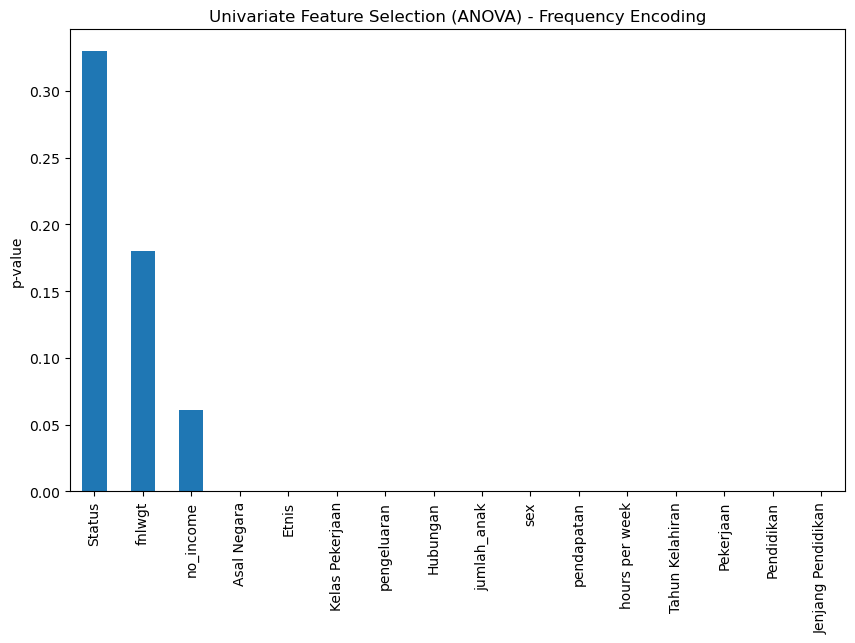

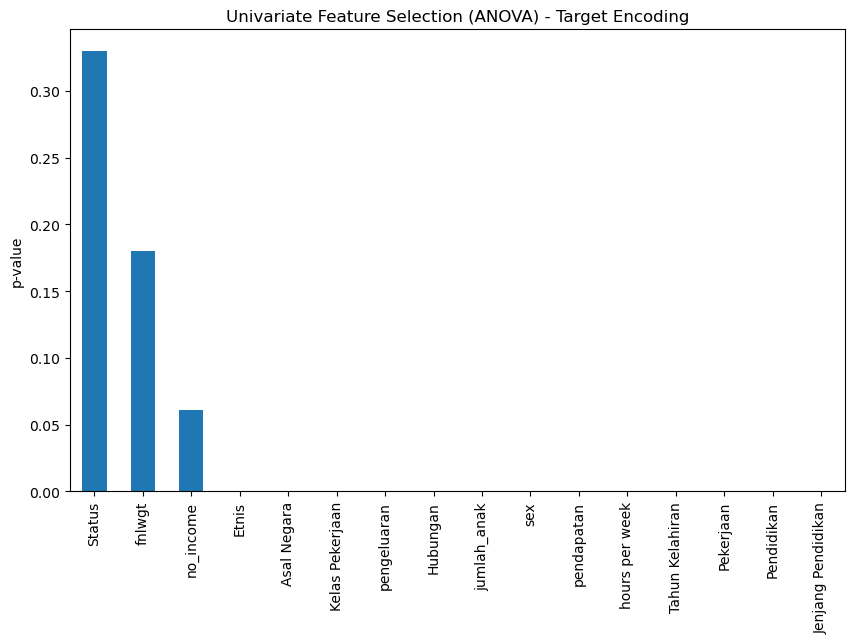

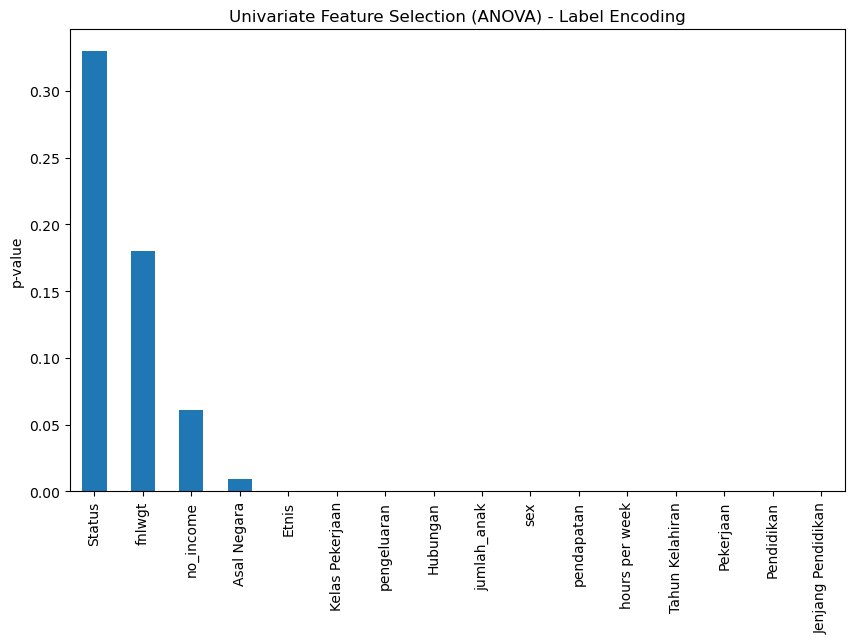

In [120]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif


def univariate_selection(df, encoding_type):
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(labels=['income'], axis=1),
        df['income'],
        test_size=0.3,
        random_state=0
    )
    
    # Applying ANOVA F-test
    univariate = f_classif(X_train, y_train)
    
    # Converting p-values to a pandas Series for easier handling
    univariate_series = pd.Series(univariate[1], index=X_train.columns)
    
    sel_ = SelectKBest(f_classif, k=10).fit(X_train, y_train)
    # Sorting and plotting the p-values
    univariate_series.sort_values(ascending=False).plot.bar(figsize=(10,6))
    plt.title(f'Univariate Feature Selection (ANOVA) - {encoding_type} Encoding')
    plt.ylabel('p-value')
    plt.show()

# List of encoded DataFrames with corresponding labels
dfs = [
    (train_anova_frequency, 'Frequency'),
    (train_anova_target, 'Target'),
    (train_anova_label, 'Label'),
]

# Running univariate selection and plotting for each encoded DataFrame
for df, encoding_type in dfs:
    univariate_selection(df, encoding_type)


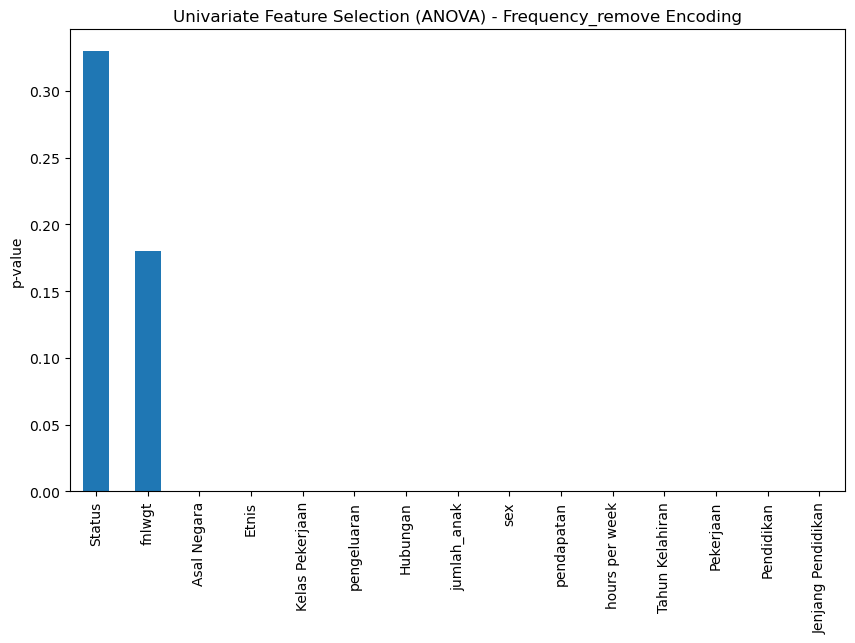

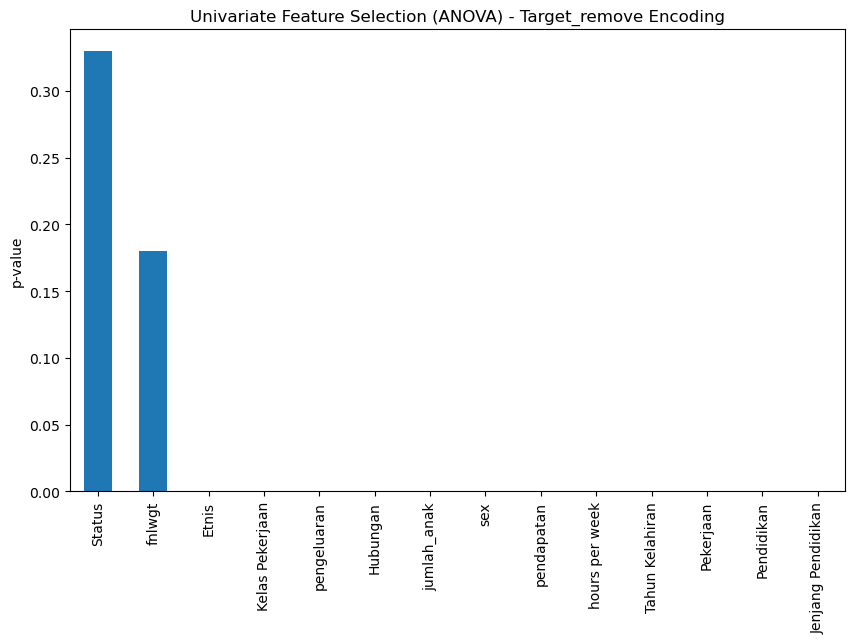

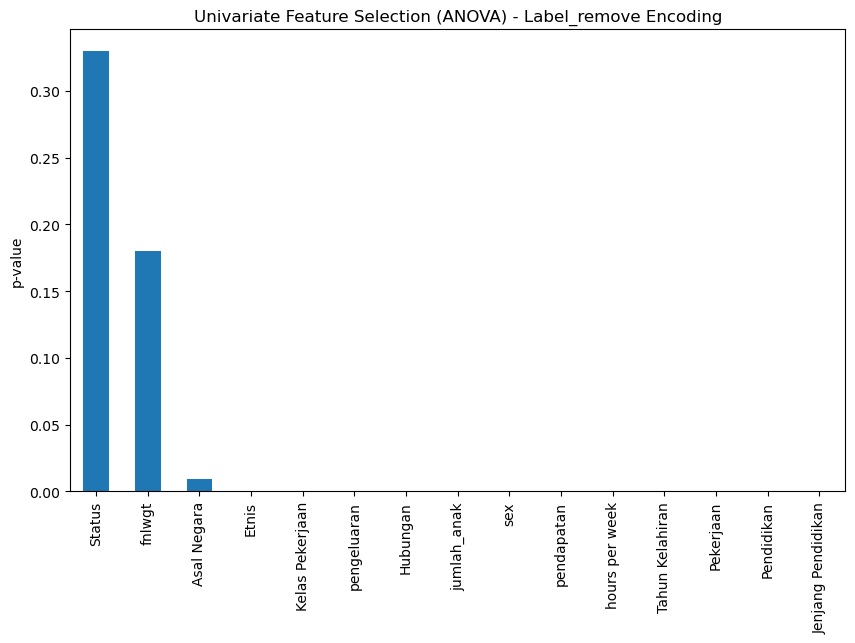

In [121]:
dfs = [
    (remove_frequency, 'Frequency_remove'),
    (remove_target, 'Target_remove'),
    (remove_label, 'Label_remove'),
]

for df, encoding_type in dfs:
    univariate_selection(df, encoding_type)


#### remove feature yang memiliki p_value besar

In [122]:
frequency_removefeature = train_anova_frequency.drop(['Status','fnlwgt','no_income'],axis=1)
target_removefeature = train_anova_target.drop(['Status','fnlwgt','no_income'],axis=1)
label_removefeature = train_anova_label.drop(['Status','fnlwgt','no_income'],axis=1)

#### Check One By One

In [123]:
# pip install catboost

In [124]:
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [125]:
def evaluate_feature_models(df):
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(labels=['income'], axis=1),
        df['income'],
        test_size=0.3,
        random_state=0
    )
    
    # Initialize models
    models = {
        'Gradient Boosting': GradientBoostingClassifier(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'CatBoost': CatBoostClassifier(silent=True),
        'LightGBM': lgb.LGBMClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVC': SVC(probability=True)
    }

    f1_scores = {model_name: [] for model_name in models.keys()}

    for feature in X_train.columns:
        for model_name, model_instance in models.items():
            # Train the model on the current feature
            model_instance.fit(X_train[feature].fillna(0).to_frame(), y_train)
            
            # Obtain predictions
            y_pred = model_instance.predict(X_test[feature].to_frame())
            
            # Calculate and store the F1 score
            f1 = f1_score(y_test, y_pred)
            f1_scores[model_name].append(f1)
    
    f1_scores_df = pd.DataFrame(f1_scores, index=X_train.columns)

    # Plot the F1 scores
    f1_scores_df.plot(kind='bar', figsize=(14, 8))
    plt.xlabel('Features')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores of Different Models by Feature')
    plt.legend(title='Models')
    plt.show()

# Train_1

Encoding Method:
- Ordinal Encoding: 
    - `Pendidikan`
    - `Jenjang Pendidikan`
- Label Encoding:
    - `income` (target variable)
    - `sex`
    - `Status`
    - `Hubungan`
- Frequent Encoding:
    - `Kelas Pekerjaan`
    - `Pekerjaan`
    - `Asal Negara`
    

In [126]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)

    missing_data = df.isnull().sum().sum()
    print('Missing data:', missing_data)

    duplicated_data = df.duplicated().sum().sum()
    print('Duplicated data:', duplicated_data)

    print('-' *50)

    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))

    print('-' *50)

check_data(train)

--------------------------------------------------
Missing data: 3414
Duplicated data: 36
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Asal Negara            458
Tahun Kelahiran          0
pendapatan               0
income                   0
jumlah_anak              0
hours per week           0
pengeluaran              0
Etnis                    0
sex                      0
Hubungan                 0
Status                   0
Jenjang Pendidikan       0
Pendidikan               0
fnlwgt                   0
no_income                0
dtype: int64
--------------------------------------------------


In [127]:
train_1 = pd.read_csv('dataset-modified/train-modified.csv')
train_1.drop_duplicates(keep='first', inplace=True)
check_data(train_1)

--------------------------------------------------
Missing data: 0
Duplicated data: 0
--------------------------------------------------
--------------------------------------------------


In [128]:
train_1.head()

,Tahun Kelahiran,Kelas Pekerjaan,no_income,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,1992,0.736521,0,37210.0,10,8,3,0.132544,4,1,1,0.0,0.0,45,0.911913,2,1
1,1981,0.736521,0,101950.0,4,2,0,0.132544,5,1,0,0.0,0.0,45,0.911913,0,0
2,2004,0.736521,0,122244.0,8,6,0,0.102530,5,1,0,0.0,0.0,28,0.911913,0,0
3,1984,0.143287,0,24763.0,2,1,1,0.051936,0,1,1,6849.0,0.0,40,0.911913,0,0
4,2000,0.736521,0,113936.0,10,8,0,0.135188,3,1,1,0.0,0.0,40,0.911913,0,0


# Feature Selection with Train_1

In [129]:
train_1_fixed = train_1.drop(['Tahun Kelahiran','no_income','Status','Hubungan','Etnis','sex','hours per week','jumlah_anak'], axis=1)

#### Model Selection


In [130]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def model_training(df):
    X = df.drop(columns=['income'])  # Fitur (semua kolom kecuali income)
    y = df['income']  # Target (kolom yang ingin diprediksi)

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate the model using F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print results
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (weighted):", f1)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [131]:
model_training(train_anova_frequency)


Accuracy: 0.8513539466103323
F1 Score (weighted): 0.8453559485902532

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      3959
           1       0.74      0.59      0.66      1248

    accuracy                           0.85      5207
   macro avg       0.81      0.76      0.78      5207
weighted avg       0.84      0.85      0.85      5207



In [132]:
model_training(train_anova_target)


Accuracy: 0.853850585749952
F1 Score (weighted): 0.8481993035383021

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      3959
           1       0.74      0.60      0.66      1248

    accuracy                           0.85      5207
   macro avg       0.81      0.77      0.78      5207
weighted avg       0.85      0.85      0.85      5207



In [133]:
model_training(train_anova_label)

Accuracy: 0.8544267332437104
F1 Score (weighted): 0.8490399953574137

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      3959
           1       0.74      0.60      0.67      1248

    accuracy                           0.85      5207
   macro avg       0.81      0.77      0.79      5207
weighted avg       0.85      0.85      0.85      5207



In [134]:
model_training(train_1)


Accuracy: 0.8540426349145381
F1 Score (weighted): 0.8477040005145298

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3953
           1       0.75      0.59      0.66      1254

    accuracy                           0.85      5207
   macro avg       0.81      0.76      0.78      5207
weighted avg       0.85      0.85      0.85      5207



In [135]:
model_training(train_1_fixed)

Accuracy: 0.7781832149030151
F1 Score (weighted): 0.7734475447534989

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      3953
           1       0.54      0.48      0.51      1254

    accuracy                           0.78      5207
   macro avg       0.69      0.68      0.68      5207
weighted avg       0.77      0.78      0.77      5207



In [136]:
model_training(frequency_removefeature)

Accuracy: 0.8450163241789899
F1 Score (weighted): 0.8403117742315749

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3959
           1       0.71      0.60      0.65      1248

    accuracy                           0.85      5207
   macro avg       0.79      0.76      0.77      5207
weighted avg       0.84      0.85      0.84      5207



In [137]:
model_training(target_removefeature)

Accuracy: 0.845400422508162
F1 Score (weighted): 0.8409772609321343

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3959
           1       0.71      0.60      0.65      1248

    accuracy                           0.85      5207
   macro avg       0.79      0.76      0.78      5207
weighted avg       0.84      0.85      0.84      5207



In [138]:
model_training(label_removefeature) 

Accuracy: 0.8446322258498176
F1 Score (weighted): 0.8396967053049734

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3959
           1       0.71      0.59      0.65      1248

    accuracy                           0.84      5207
   macro avg       0.79      0.76      0.77      5207
weighted avg       0.84      0.84      0.84      5207



In [139]:
from sklearn.ensemble import RandomForestClassifier
X = train_anova_label.drop(columns=['no_income','income'])  # Fitur (semua kolom kecuali income)
y = train_anova_label['income']  # Target (kolom yang ingin diprediksi)

    # Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

    # Create a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=80, random_state=1000)
# 1000 1000
# Train the model
rf.fit(X_train, y_train)

    # Make predictions
y_pred = rf.predict(X_test)

    # Evaluate the model using F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

    # Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8623007489917419
F1 Score (weighted): 0.858064718952005

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      3978
           1       0.75      0.63      0.68      1229

    accuracy                           0.86      5207
   macro avg       0.82      0.78      0.80      5207
weighted avg       0.86      0.86      0.86      5207



In [140]:
from pycaret.classification import *
import pandas as pd
import numpy as np

# Combine into a single DataFrame
data = train_anova_label.drop('no_income', axis=1)

# Initialize the PyCaret classification setup
classification_setup = setup(data, target='income', session_id=123)

# Compare baseline models based on weighted F1 score
best_model = compare_models(sort='F1', fold=5)

# Create and train the best model
model = create_model(best_model)

# Tune the model based on weighted F1 score
tuned_model = tune_model(model, optimize='F1')

# Finalize the model
final_model = finalize_model(tuned_model)

# Make predictions
predictions = predict_model(final_model, data=X_train)

# Evaluate model performance
evaluate_model(final_model)


,Description,Value
0,Session id,123
1,Target,income
2,Target type,Binary
3,Original data shape,"(26035, 16)"
4,Transformed data shape,"(26035, 16)"
5,Transformed train set shape,"(18224, 16)"
6,Transformed test set shape,"(7811, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8682,0.9221,0.6417,0.7730,0.7010,0.6175,0.6220,0.2120
xgboost,Extreme Gradient Boosting,0.8643,0.9182,0.6472,0.7547,0.6967,0.6100,0.6131,0.1000
catboost,CatBoost Classifier,0.8668,0.9223,0.6344,0.7724,0.6964,0.6122,0.6171,4.0160
gbc,Gradient Boosting Classifier,0.8638,0.9184,0.5998,0.7843,0.6795,0.5950,0.6037,0.5340
ada,Ada Boost Classifier,0.8572,0.9098,0.5902,0.7634,0.6655,0.5766,0.5845,0.1740
rf,Random Forest Classifier,0.8534,0.9041,0.6025,0.7408,0.6644,0.5719,0.5770,0.3740
et,Extra Trees Classifier,0.8408,0.8878,0.5938,0.6999,0.6425,0.5410,0.5440,0.3080
dt,Decision Tree Classifier,0.8090,0.7420,0.6125,0.6019,0.6071,0.4810,0.4811,0.0380
lr,Logistic Regression,0.8317,0.8540,0.4740,0.7330,0.5757,0.4767,0.4943,1.7520
lda,Linear Discriminant Analysis,0.8237,0.8600,0.4610,0.7050,0.5574,0.4534,0.4693,0.0440


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8711,0.9331,0.6469,0.7802,0.7073,0.6256,0.6301
1,0.8634,0.9185,0.6241,0.7654,0.6876,0.6013,0.6065
2,0.8678,0.9230,0.6424,0.7705,0.7006,0.6167,0.6209
3,0.8623,0.9245,0.6469,0.7474,0.6935,0.6053,0.6080
4,0.8694,0.9221,0.6538,0.7694,0.7069,0.6236,0.6270
5,0.8628,0.9182,0.6036,0.7771,0.6795,0.5939,0.6016
6,0.8672,0.9266,0.6811,0.7456,0.7119,0.6258,0.6269
7,0.8644,0.9183,0.6492,0.7540,0.6977,0.6109,0.6138
8,0.8628,0.9188,0.5968,0.7821,0.6770,0.5919,0.6006


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8678,0.9316,0.6515,0.7647,0.7036,0.6192,0.6225
1,0.8678,0.9160,0.6264,0.7812,0.6953,0.6122,0.6183
2,0.8667,0.9242,0.6538,0.7593,0.7026,0.6173,0.6202
3,0.8579,0.9184,0.6355,0.7381,0.6830,0.5921,0.5948
4,0.8699,0.9219,0.6424,0.7790,0.7041,0.6217,0.6265
5,0.8606,0.9143,0.6082,0.7650,0.6777,0.5902,0.5965
6,0.8683,0.9239,0.6697,0.7558,0.7101,0.6253,0.6272
7,0.8655,0.9178,0.6492,0.7580,0.6994,0.6134,0.6165
8,0.8644,0.9155,0.5923,0.7927,0.6780,0.5944,0.6045


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [141]:
from pycaret.classification import *

# Initialize the PyCaret classification setup
classification_setup = setup(data, target='income', session_id=123)

# Create and tune the LightGBM model
lightgbm_model = create_model('lightgbm')
tuned_lightgbm_model = tune_model(lightgbm_model, optimize='F1')

# Finalize the model
final_lightgbm_model = finalize_model(tuned_lightgbm_model)

# Evaluate the model
evaluate_model(final_lightgbm_model)

,Description,Value
0,Session id,123
1,Target,income
2,Target type,Binary
3,Original data shape,"(26035, 16)"
4,Transformed data shape,"(26035, 16)"
5,Transformed train set shape,"(18224, 16)"
6,Transformed test set shape,"(7811, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8711,0.9331,0.6469,0.7802,0.7073,0.6256,0.6301
1,0.8634,0.9185,0.6241,0.7654,0.6876,0.6013,0.6065
2,0.8678,0.9230,0.6424,0.7705,0.7006,0.6167,0.6209
3,0.8623,0.9245,0.6469,0.7474,0.6935,0.6053,0.6080
4,0.8694,0.9221,0.6538,0.7694,0.7069,0.6236,0.6270
5,0.8628,0.9182,0.6036,0.7771,0.6795,0.5939,0.6016
6,0.8672,0.9266,0.6811,0.7456,0.7119,0.6258,0.6269
7,0.8644,0.9183,0.6492,0.7540,0.6977,0.6109,0.6138
8,0.8628,0.9188,0.5968,0.7821,0.6770,0.5919,0.6006


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8678,0.9316,0.6515,0.7647,0.7036,0.6192,0.6225
1,0.8678,0.9160,0.6264,0.7812,0.6953,0.6122,0.6183
2,0.8667,0.9242,0.6538,0.7593,0.7026,0.6173,0.6202
3,0.8579,0.9184,0.6355,0.7381,0.6830,0.5921,0.5948
4,0.8699,0.9219,0.6424,0.7790,0.7041,0.6217,0.6265
5,0.8606,0.9143,0.6082,0.7650,0.6777,0.5902,0.5965
6,0.8683,0.9239,0.6697,0.7558,0.7101,0.6253,0.6272
7,0.8655,0.9178,0.6492,0.7580,0.6994,0.6134,0.6165
8,0.8644,0.9155,0.5923,0.7927,0.6780,0.5944,0.6045


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [142]:
# predict_model(final_lightgbm_model, )

# untuk test data

In [143]:
test = pd.read_csv('dataset/test.csv')

test['Pendidikan'] = test['Pendidikan'].replace(['kelas 10', 'kelas 11', 'kelas 12'], 'SMA')

# replace kelas 7-8, kelas 9 with SMP
test['Pendidikan'] = test['Pendidikan'].replace(['kelas 7-8', 'kelas 9'], 'SMP')

# replace kelas 1-4, kelas 5-6 with SD
test['Pendidikan'] = test['Pendidikan'].replace(['kelas 1-4', 'kelas 5-6'], 'SD')

test['Status'] = test['Status'].replace(['Menikahi tentara', 'LDM'], 'Menikah')

test['Kelas Pekerjaan'] = test['Kelas Pekerjaan'].replace(['Pemerintah pusat', 'Pemerintah daerah',
                                                             'Pemerintah negara'], 'Sektor Pemerintah')
test['no_income'] = test['Kelas Pekerjaan'].apply(lambda x: 1 if x == 'Tanpa bayaran' or x == 'Tidak bekerja' else 0)

# replace SMA_1, SMA_2, SMA_3 with SMA
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['SMA_1', 'SMA_2', 'SMA_3'], 'SMA')

# replace SMP_1, SMP_2, SMP_3 with SMP
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['SMP_1', 'SMP_2', 'SMP_3'], 'SMP')

# replace SD_1, SD_2, with SD
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['SD_1', 'SD_2'], 'SD')

# replace vokasi Grad_1, vokasi Grad_2 with vokasi Grad
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['vokasi Grad_1', 'vokasi Grad_2'], 'Vokasi Grad')

test['Asal Negara'] = test['Asal Negara'].replace(['?'], np.nan)

# replace "Hong" with "Hong Kong"
test['Asal Negara'] = test['Asal Negara'].replace(['Hong'], 'Hong Kong')

missing_cols = ['Kelas Pekerjaan', 'Pekerjaan', 'Asal Negara']

for col in missing_cols:
    test[col] = test[col].fillna(method='ffill')

# drop duplucated
test.drop_duplicates(keep='first', inplace=True)

test['Pendidikan'] = test['Pendidikan'].map(mapping_pendidikan)

test['Status'] = test['Status'].map(mapping_status)

test['Kelas Pekerjaan'] = test['Kelas Pekerjaan'].map(mappingKelas_Pekerjaan)

test['Pekerjaan'] = test['Pekerjaan'].map(mapping_pekerjaan)

test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].map(mapping_jenjangpendidikan)

test['Asal Negara'] = test['Asal Negara'].map(mapping_countries).fillna(test['Asal Negara'])

test['Hubungan'] = test['Hubungan'].map(mapping_status_keluarga)


le = LabelEncoder()

test['sex'] = le.fit_transform(test['sex'])
test['sex'] = le.fit_transform(test['sex'])

test['Asal Negara'] = le.fit_transform(test['Asal Negara'])

In [144]:
check_data(test)

--------------------------------------------------
Missing data: 0
Duplicated data: 0
--------------------------------------------------
--------------------------------------------------


In [145]:
test.to_csv('fixed_test.csv', index=False)

In [146]:
test.head()

,ID,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income
0,1,1993,4,117963,10,10,0,2,5,1,1,0,0,40,37,0,0
1,2,2004,4,201490,5,6,0,2,5,1,1,0,0,40,37,0,0
2,3,1946,4,385242,8,7,1,1,4,1,1,9386,0,45,37,2,0
3,4,1992,2,164197,8,7,1,9,4,1,1,0,0,44,37,0,0
4,5,1963,2,92691,4,4,1,4,4,1,1,0,0,3,37,0,0


In [147]:
train_anova_label.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,2,37210,8,7,1,1,4,1,1,0,0,45,38,2,1,0
1,1981,2,101950,9,8,0,1,0,1,0,0,0,45,38,0,0,0
2,2004,2,122244,4,4,0,1,0,1,0,0,0,28,38,0,0,0
3,1984,5,24763,5,6,3,6,1,1,1,6849,0,40,38,0,0,0
4,2000,2,113936,8,7,0,2,5,1,1,0,0,40,38,0,0,0


In [148]:
# import lgbm
from lightgbm import LGBMClassifier

X = train_anova_label.drop(['income'], axis=1)  # Fitur (semua kolom kecuali target)
y = train_anova_label['income']  # Target

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model LightGBM
model = LGBMClassifier(
    objective='binary',            # Ganti dengan objective sesuai kebutuhan (misalnya 'regression' untuk regresi)
    metric='binary_error',         # Metrik yang digunakan untuk evaluasi model
    n_estimators=100,              # Jumlah estimasi (trees)
    learning_rate=0.1,             # Kecepatan pembelajaran
    num_leaves=31,                 # Jumlah daun pada setiap pohon
    max_depth=-1,                  # Kedalaman maksimum pohon, -1 berarti tidak ada batas
    min_child_samples=20,          # Jumlah minimal sampel di setiap daun
    subsample=0.8,                 # Rasio sampel yang digunakan untuk membangun setiap pohon
    colsample_bytree=0.8,          # Rasio kolom yang digunakan untuk membangun setiap pohon
    random_state=42
)

# Latih model
model.fit(X_train, y_train)

# Lakukan prediksi pada data test
test_pred = model.predict(test.drop('ID',axis=1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5024, number of negative: 15804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241214 -> initscore=-1.146037
[LightGBM] [Info] Start training from score -1.146037


In [149]:
test_pred

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [150]:
pycaret_model_df = predict_model(final_lightgbm_model, test.drop('ID', axis=1))
pycaret_model_df.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income,prediction_label,prediction_score
0,1993,4,117963,10,10,0,2,5,1,1,0,0,40,37,0,0,0,0.9190
1,2004,4,201490,5,6,0,2,5,1,1,0,0,40,37,0,0,0,0.9987
2,1946,4,385242,8,7,1,1,4,1,1,9386,0,45,37,2,0,1,0.9857
3,1992,2,164197,8,7,1,9,4,1,1,0,0,44,37,0,0,0,0.5617
4,1963,2,92691,4,4,1,4,4,1,1,0,0,3,37,0,0,0,0.9052


In [151]:
pycaret_model_df['prediction_label']

0       0
1       0
2       1
3       0
4       0
       ..
6508    0
6509    0
6510    1
6511    0
6512    0
Name: prediction_label, Length: 6513, dtype: int32

In [152]:

submission_normal_lgbm = pd.DataFrame({
    'ID': test['ID'],  # Ganti 'Id' dengan kolom ID di dataset Anda
    'income': test_pred  # Ganti 'target' dengan nama kolom target yang sesuai
})


In [153]:

submission_pycaret_lgbm = pd.DataFrame({
    'ID': test['ID'],  # Ganti 'Id' dengan kolom ID di dataset Anda
    'income': pycaret_model_df['prediction_label']  # Ganti 'target' dengan nama kolom target yang sesuai
})


In [154]:
submission_normal_lgbm

,ID,income
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
6508,6509,0
6509,6510,0
6510,6511,1
6511,6512,0


In [155]:
submission_pycaret_lgbm = pd.DataFrame({
    'ID': test['ID'],  # Ganti 'Id' dengan kolom ID di dataset Anda
    'income': pycaret_model_df['prediction_label']  # Ganti 'target' dengan nama kolom target yang sesuai
})


In [156]:
submission_pycaret_lgbm['income'].value_counts()

income
0    5191
1    1322
Name: count, dtype: int64

In [157]:
submission_pycaret_lgbm

,ID,income
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
6508,6509,0
6509,6510,0
6510,6511,1
6511,6512,0


In [158]:
submission_pycaret_lgbm.to_csv('submission__pycaret_lgbm.csv', index=False)

Sampling

In [159]:
train_anova_label

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,2,37210,8,7,1,1,4,1,1,0,0,45,38,2,1,0
1,1981,2,101950,9,8,0,1,0,1,0,0,0,45,38,0,0,0
2,2004,2,122244,4,4,0,1,0,1,0,0,0,28,38,0,0,0
3,1984,5,24763,5,6,3,6,1,1,1,6849,0,40,38,0,0,0
4,2000,2,113936,8,7,0,2,5,1,1,0,0,40,38,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26045,1969,2,82098,4,4,1,1,4,3,1,0,0,55,38,1,0,0
26046,1998,2,50053,8,7,1,1,4,1,1,0,0,55,38,0,0,0
26047,2005,2,415354,3,3,3,12,0,1,0,0,0,40,38,3,0,0
26049,2004,2,122244,4,4,0,5,0,1,0,0,0,28,38,0,0,0


In [160]:
train_anova_label['income'].value_counts()

income
0    19763
1     6272
Name: count, dtype: int64

In [172]:
from imblearn.combine import SMOTETomek

In [161]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2021
)

In [173]:
smote = SMOTETomek(random_state=2021)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)

In [174]:
pd.Series(y_train_over).value_counts()

income
0    14011
1    14011
Name: count, dtype: int64

In [175]:
train_anova_label.columns

Index(['Tahun Kelahiran', 'Kelas Pekerjaan', 'fnlwgt', 'Pendidikan',
       'Jenjang Pendidikan', 'Status', 'Pekerjaan', 'Hubungan', 'Etnis', 'sex',
       'pendapatan', 'pengeluaran', 'hours per week', 'Asal Negara',
       'jumlah_anak', 'income', 'no_income'],
      dtype='object')

In [176]:
df = pd.DataFrame(data=X_train_over, columns=X.columns)
df['Target'] = y_train_over
df.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income,Target
0,1991,2,143540,4,4,1,9,4,1,1,0,0,40,38,0,0,0
1,1995,2,128604,4,4,1,9,4,3,1,0,0,40,38,3,0,0
2,1986,5,414791,8,7,1,1,4,1,1,0,0,42,38,0,0,1
3,1976,2,140782,9,8,1,1,3,1,0,0,1902,38,38,1,0,1
4,1991,2,163110,4,4,1,8,4,1,1,3781,0,40,38,1,0,0


In [178]:
clf1 = setup(data = df, 
            #  silent=True,
             target = 'Target', 
             fix_imbalance = True,
             fix_imbalance_method=smote
            )

,Description,Value
0,Session id,6789
1,Target,Target
2,Target type,Binary
3,Original data shape,"(28022, 17)"
4,Transformed data shape,"(26911, 17)"
5,Transformed train set shape,"(18504, 17)"
6,Transformed test set shape,"(8407, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


create model

In [188]:
from pycaret.classification import *

# Initialize the PyCaret classification setup with SMOTE
classification_setup = setup(data=data, target='income', session_id=123, fix_imbalance=True, fix_imbalance_method=smote)

# Compare models to select the best one
best_model = compare_models()

# Proceed with model creation, tuning, and finalization
tuned_model = tune_model(best_model, optimize='F1')
final_model = finalize_model(tuned_model)

predictions_sampling = predict_model(final_model, data=test)
predictions_sampling

,Description,Value
0,Session id,123
1,Target,income
2,Target type,Binary
3,Original data shape,"(26035, 16)"
4,Transformed data shape,"(32159, 16)"
5,Transformed train set shape,"(24348, 16)"
6,Transformed test set shape,"(7811, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8674,0.9206,0.6567,0.7604,0.7045,0.6197,0.6226,0.3300
catboost,CatBoost Classifier,0.8651,0.9196,0.6506,0.7557,0.6990,0.6127,0.6157,6.0540
xgboost,Extreme Gradient Boosting,0.8633,0.9172,0.6501,0.7495,0.6960,0.6085,0.6112,0.2150
gbc,Gradient Boosting Classifier,0.8523,0.9104,0.6704,0.7030,0.6861,0.5897,0.5901,0.9280
rf,Random Forest Classifier,0.8482,0.8992,0.6376,0.7044,0.6692,0.5710,0.5723,0.6270
et,Extra Trees Classifier,0.8383,0.8887,0.6285,0.6770,0.6517,0.5466,0.5473,0.4790
ada,Ada Boost Classifier,0.8375,0.8993,0.6863,0.6555,0.6704,0.5626,0.5630,0.3610
qda,Quadratic Discriminant Analysis,0.8260,0.8560,0.5501,0.6692,0.6036,0.4936,0.4976,0.1420
dt,Decision Tree Classifier,0.8016,0.7374,0.6134,0.5843,0.5983,0.4667,0.4671,0.1730
nb,Naive Bayes,0.7933,0.8294,0.3116,0.6484,0.4208,0.3133,0.3446,0.1410


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8656,0.9248,0.6743,0.7437,0.7073,0.6203,0.6216
1,0.8651,0.9124,0.6264,0.7703,0.6910,0.6058,0.6111
2,0.8629,0.9222,0.6310,0.7589,0.6891,0.6020,0.6063
3,0.8596,0.9174,0.6355,0.7440,0.6855,0.5958,0.5989
4,0.8677,0.9197,0.6424,0.7705,0.7006,0.6166,0.6208
5,0.8595,0.9131,0.6333,0.7453,0.6847,0.5951,0.5984
6,0.8655,0.9210,0.6743,0.7437,0.7073,0.6203,0.6215
7,0.8672,0.9161,0.6651,0.7545,0.7070,0.6216,0.6236
8,0.8562,0.9135,0.5900,0.7595,0.6641,0.5745,0.5819


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,ID,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income,prediction_label,prediction_score
0,1,1993,4,117963,10,10,0,2,5,1,1,0,0,40,37,0,0,0,0.9206
1,2,2004,4,201490,5,6,0,2,5,1,1,0,0,40,37,0,0,0,0.9989
2,3,1946,4,385242,8,7,1,1,4,1,1,9386,0,45,37,2,0,1,0.9912
3,4,1992,2,164197,8,7,1,9,4,1,1,0,0,44,37,0,0,1,0.5451
4,5,1963,2,92691,4,4,1,4,4,1,1,0,0,3,37,0,0,0,0.8707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,6509,1982,3,32185,8,7,1,10,4,1,1,0,0,60,37,0,0,0,0.6756
6509,6510,1990,2,180714,5,6,1,6,4,2,1,0,2179,40,37,1,0,0,0.8587
6510,6511,1985,2,202027,11,9,1,2,4,1,1,0,0,45,37,2,0,1,0.9164
6511,6512,1995,2,125976,4,4,4,5,1,1,0,0,0,35,37,1,0,0,0.9908


In [189]:
predictions_sampling = predict_model(final_model, data=test)
predictions_sampling

,ID,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income,prediction_label,prediction_score
0,1,1993,4,117963,10,10,0,2,5,1,1,0,0,40,37,0,0,0,0.9206
1,2,2004,4,201490,5,6,0,2,5,1,1,0,0,40,37,0,0,0,0.9989
2,3,1946,4,385242,8,7,1,1,4,1,1,9386,0,45,37,2,0,1,0.9912
3,4,1992,2,164197,8,7,1,9,4,1,1,0,0,44,37,0,0,1,0.5451
4,5,1963,2,92691,4,4,1,4,4,1,1,0,0,3,37,0,0,0,0.8707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,6509,1982,3,32185,8,7,1,10,4,1,1,0,0,60,37,0,0,0,0.6756
6509,6510,1990,2,180714,5,6,1,6,4,2,1,0,2179,40,37,1,0,0,0.8587
6510,6511,1985,2,202027,11,9,1,2,4,1,1,0,0,45,37,2,0,1,0.9164
6511,6512,1995,2,125976,4,4,4,5,1,1,0,0,0,35,37,1,0,0,0.9908


In [190]:
submission_oversamping_smote = pd.DataFrame({
    'ID': test['ID'],  # Ganti 'Id' dengan kolom ID di dataset Anda
    'income': predictions_sampling['prediction_label']  # Ganti 'target' dengan nama kolom target yang sesuai
})

submission_oversamping_smote.head(20)

,ID,income
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [191]:
submission_oversamping_smote.income.value_counts()

income
0    5161
1    1352
Name: count, dtype: int64

In [192]:
submission_oversamping_smote.to_csv('submission/submission_oversamping_smote_pycaret_222.csv', index=False)

In [162]:
# # plot the percentage of train_anova_label['income'].value_counts() using pie chart
# plt.pie(train_anova_label['income'].value_counts(), labels=train_anova_label['income'].value_counts().index, autopct='%1.1f%%')
# plt.show()

Try oversampling with fix_imbalanced

In [163]:
# from pycaret.classification import *

# # Initialize the PyCaret classification setup with SMOTE
# classification_setup = setup(data=data, target='income', session_id=123, fix_imbalance=True, fix_imbalance_method='smote')

# # Compare models to select the best one
# best_model = compare_models()

# # Proceed with model creation, tuning, and finalization
# tuned_model = tune_model(best_model, optimize='F1')
# final_model = finalize_model(tuned_model)

In [164]:
# # Make predictions on the test set
# predictions_sampling = predict_model(final_model, data=test)
# predictions_sampling

In [165]:
# predictions_sampling['prediction_label'].value_counts()

In [166]:
# submission_oversamping_smote = pd.DataFrame({
#     'ID': test['ID'],  # Ganti 'Id' dengan kolom ID di dataset Anda
#     'income': predictions_sampling['prediction_label']  # Ganti 'target' dengan nama kolom target yang sesuai
# })

# submission_oversamping_smote.head(20)

In [167]:
# submission_pycaret_lgbm['income'].value_counts()

In [168]:
# submission_normal_lgbm['income'].value_counts()

In [169]:
# submission_oversamping_smote['income'].value_counts()

In [170]:
# submission_oversamping_smote.to_csv('submission_oversamping_smote.csv', index=False)